In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import pygalmesh
import meshio
from mpi4py import MPI
import fenics as fe
import fenics_adjoint as fa
import torch
import torch.nn.functional as F
import torch_fenics

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

--------------------------------------------------------------------------

  Local host:   dv002
  Local device: mlx5_0
--------------------------------------------------------------------------


# Load lung CT image data

In [3]:
case_name = 'Case1Pack'
ee_phase = 50
ei_phase = 0
lung_roi = 'lung_combined_mask'

In [6]:
ds = project.imaging.Emory4DCTDataset(
    data_root='../data/Emory-4DCT',
    case_names=[case_name],
    phases=[ei_phase, ee_phase]
)
ds.load_niftis()
ds.load_masks(roi=['lung_combined_mask'])
ds.load_displacements(fixed_phase=ee_phase)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T50.nii.gz


In [9]:
case = ds[0]
resolution = list(case.resolution) # mm
print(resolution)

ee_anat_image = case.array.sel(phase=ee_phase)
ei_anat_image = case.array.sel(phase=ei_phase)

rho_water = 1000 # kg / m^3
ee_rho_image = rho_water * (1 + ee_anat_image / 1000)
ei_rho_image = rho_water * (1 + ee_anat_image / 1000)

ee_lung_mask = case.mask.sel(phase=ee_phase, roi=lung_roi)
ei_lung_mask = case.mask.sel(phase=ei_phase, roi=lung_roi)

ee_overlay = (ee_lung_mask + 1) / 2
ei_overlay = (ei_lung_mask + 1) / 2

reg_disp_image = case.disp.sel(phase=0)
reg_disp_image *= xr.DataArray(resolution, dims=['component'], coords={'component': ['x', 'y', 'z']}) # mm

[0.97, 0.97, 2.5]


<IPython.core.display.Javascript object>


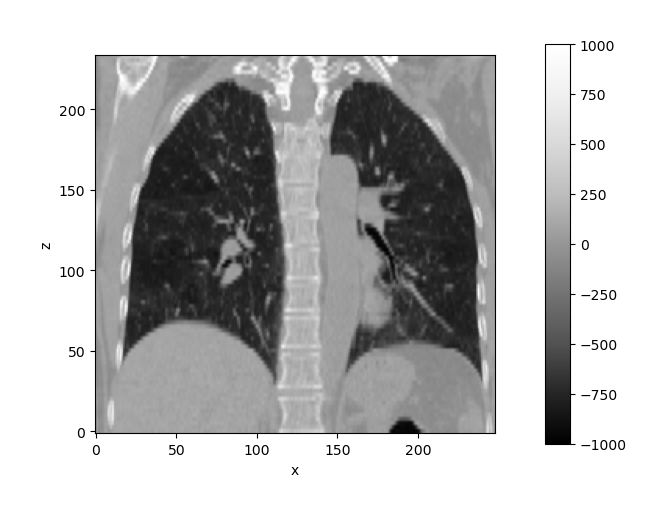

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


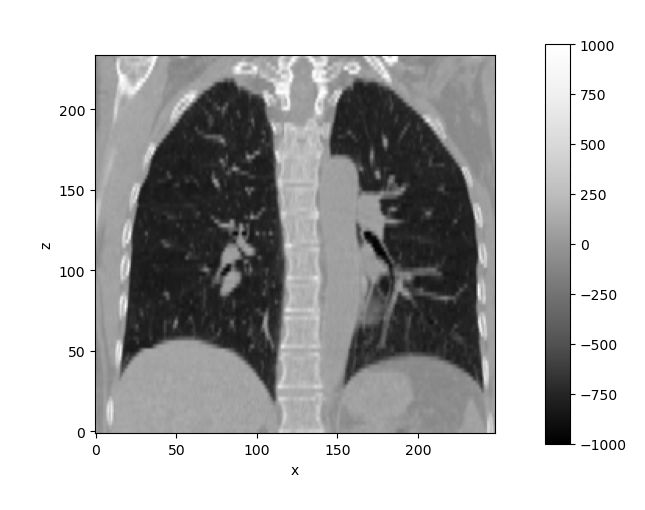

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


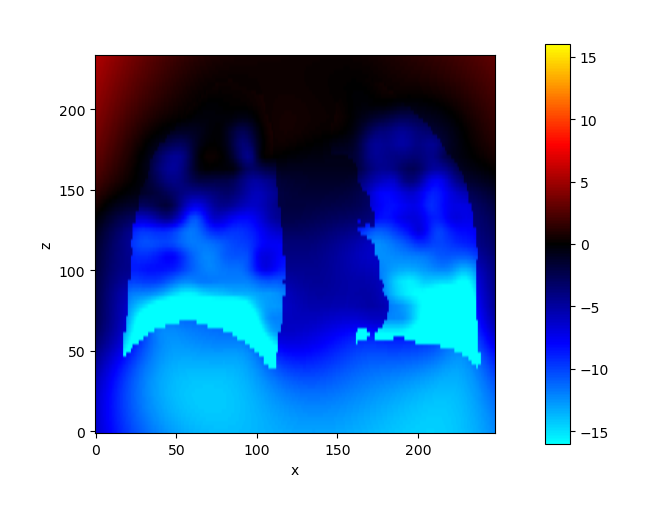

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


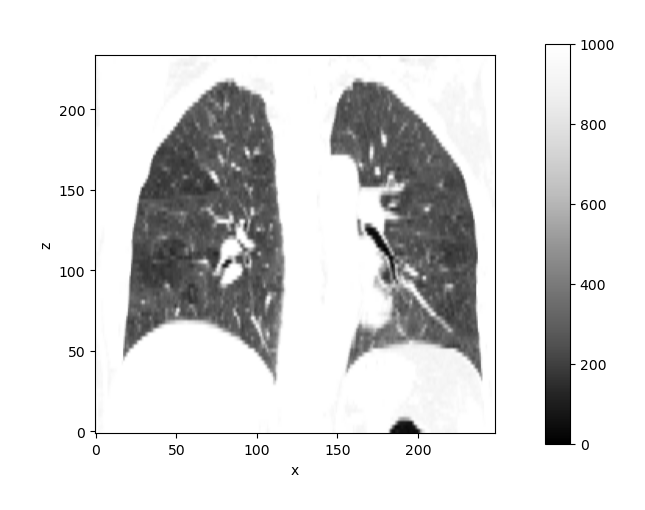

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


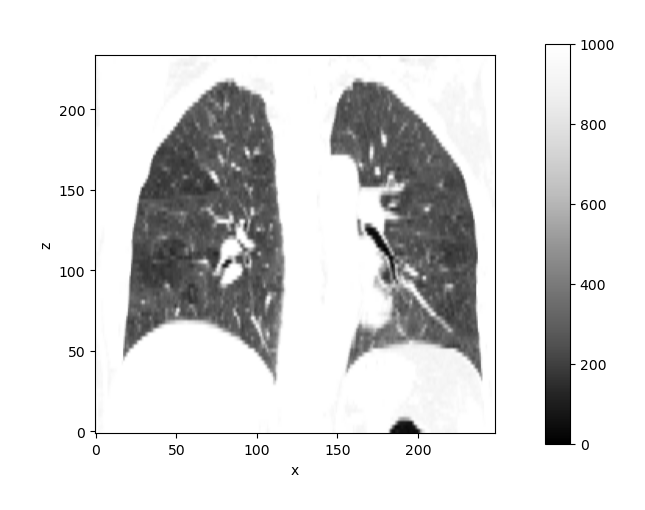

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [10]:
project.visual.view(ee_anat_image, x='x', y='z', cmap='Greys_r', vmin=-1000, vmax=1000).update_index(y=140)
project.visual.view(ei_anat_image, x='x', y='z', cmap='Greys_r', vmin=-1000, vmax=1000).update_index(y=140)
project.visual.view(reg_disp_image * ee_overlay, x='x', y='z').update_index(y=140, component=2)
project.visual.view(ee_rho_image, x='x', y='z', cmap='Greys_r', vmin=0, vmax=1000).update_index(y=140)
project.visual.view(ei_rho_image, x='x', y='z', cmap='Greys_r', vmin=0, vmax=1000).update_index(y=140)

# Anatomical mesh generation

In [12]:
%%time
ee_lung_mesh = pygalmesh.generate_from_array(
    ee_lung_mask.values.astype(np.uint16),
    voxel_size=resolution,
    max_cell_circumradius=5.0, # mm
    odt=True
)
ee_lung_mesh = project.meshing.remove_unused_points(ee_lung_mesh)
ee_lung_mesh

CPU times: user 5.15 s, sys: 27.5 ms, total: 5.18 s
Wall time: 5.19 s


<meshio mesh object>
  Number of points: 14066
  Number of cells:
    triangle: 19468
    tetra: 69594

In [13]:
%%time
vertices = ee_lung_mesh.points
facets = ee_lung_mesh.cells[0].data
tetras = ee_lung_mesh.cells[1].data

tetra_facets = np.concatenate([
    tetras[:,[0,1,2]],
    tetras[:,[0,1,3]],
    tetras[:,[0,2,3]],
    tetras[:,[1,2,3]],
    
    tetras[:,[2,1,0]],
    tetras[:,[3,1,0]],
    tetras[:,[3,2,0]],
    tetras[:,[3,2,1]],
])

#angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)
#tetra_angles = project.meshing.compute_angles_to_interior(vertices, tetra_facets, tetras)

vertices.shape, facets.shape, tetras.shape

CPU times: user 5.89 ms, sys: 196 µs, total: 6.08 ms
Wall time: 4.55 ms


((14066, 3), (19468, 3), (69594, 4))

<IPython.core.display.Javascript object>


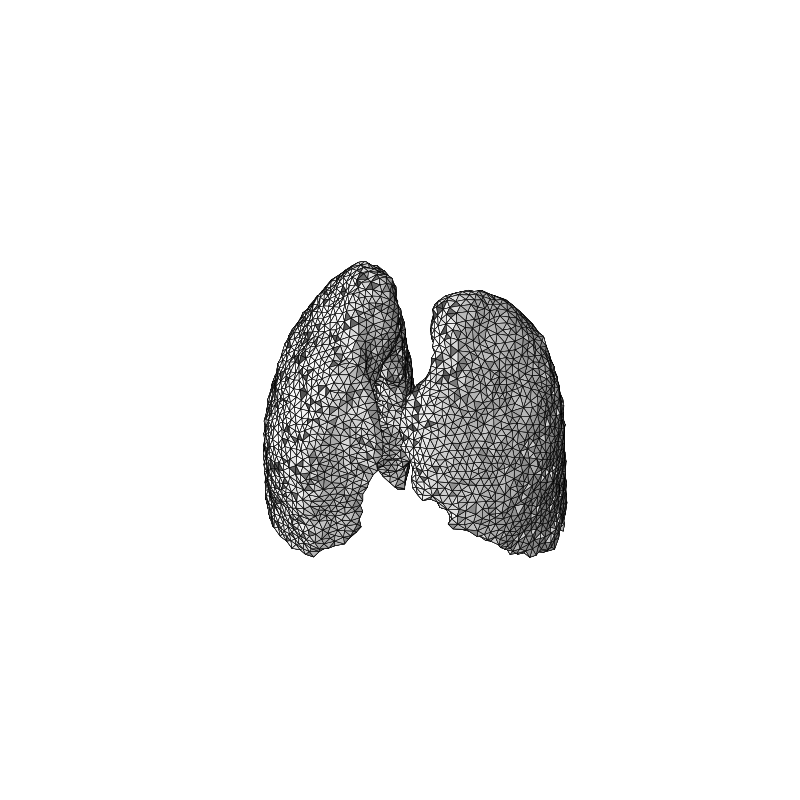

In [14]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets, #[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

<IPython.core.display.Javascript object>


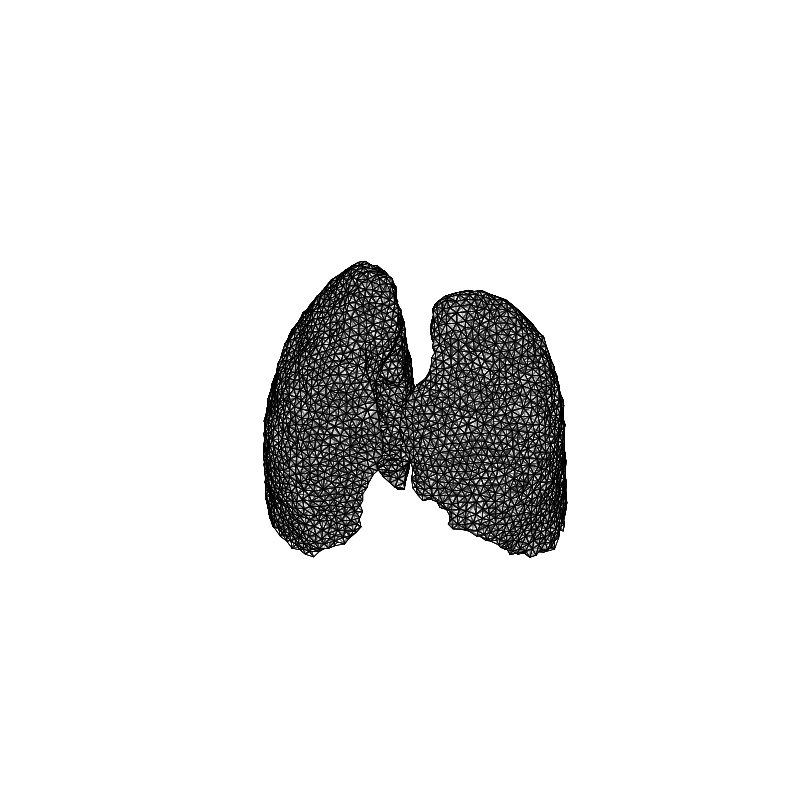

In [15]:
# view volume mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    tetra_facets,
    facecolors='white',
    edgecolors='black',
    alpha=0.1,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

In [16]:
def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

ee_lung_fe_mesh = convert_to_fe_mesh(ee_lung_mesh.points, ee_lung_mesh.cells[1])
#ee_lung_fe_mesh

In [17]:
%%time
u_tensor = torch.as_tensor(reg_disp_image.values)
print(u_tensor.shape)

u_func_space = fe.VectorFunctionSpace(ee_lung_fe_mesh, 'P', 1)
u_func_dofs = project.interpolate.image_to_dofs(u_tensor, resolution, u_func_space)
print(u_func_dofs.shape)

torch.Size([256, 256, 94, 3])
torch.Size([14066, 3])
CPU times: user 308 ms, sys: 16 ms, total: 324 ms
Wall time: 545 ms


In [18]:
%%time
u_interp = project.interpolate.dofs_to_image(u_func_dofs, u_func_space, case.shape, resolution)
print(u_interp.shape)

(256, 256, 94, 3)
CPU times: user 3min 9s, sys: 87.5 ms, total: 3min 9s
Wall time: 3min 10s


<IPython.core.display.Javascript object>


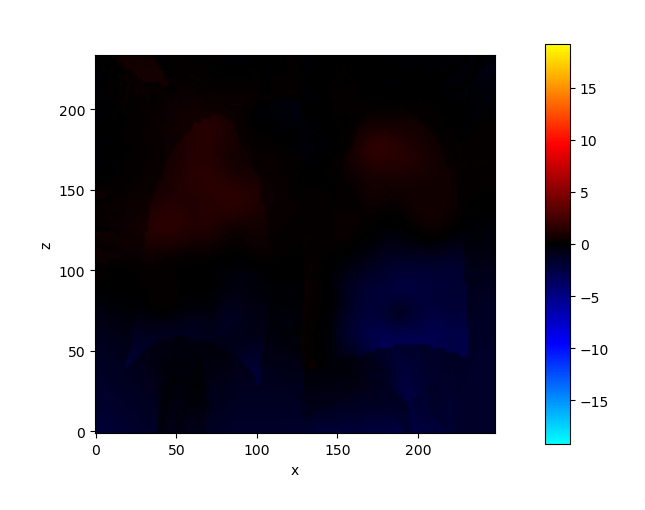

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


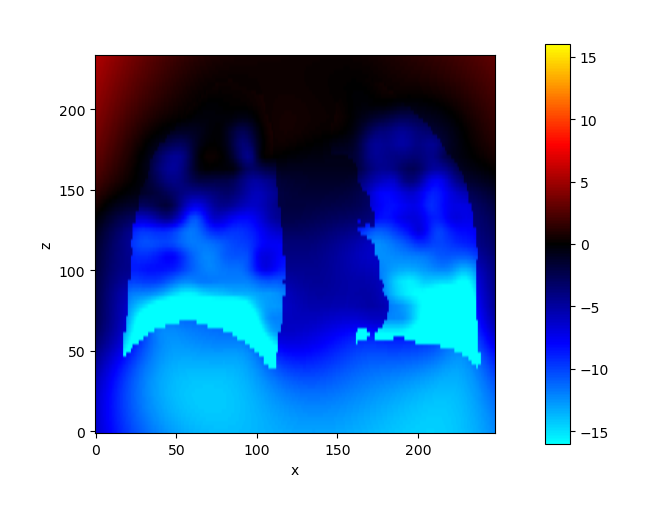

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [21]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_interp) * ee_overlay, x='x', y='z').update_index(y=140, component=2)
project.visual.XArrayViewer(reg_disp_image * ee_overlay, x='x', y='z').update_index(y=140, component=2)

In [22]:
%%time
rho_tensor = torch.as_tensor(ee_rho_image.values)
print(rho_tensor.shape)

rho_func_space = fe.FunctionSpace(ee_lung_fe_mesh, 'P', 1)
rho_func_dofs = project.interpolate.image_to_dofs(rho_tensor, resolution, rho_func_space)
print(rho_func_dofs.shape)

torch.Size([256, 256, 94])
torch.Size([14066])
CPU times: user 129 ms, sys: 3 ms, total: 132 ms
Wall time: 126 ms


In [23]:
%%time
rho_interp = project.interpolate.dofs_to_image(rho_func_dofs, rho_func_space, case.shape, resolution)
print(rho_interp.shape)

(256, 256, 94)
CPU times: user 3min 2s, sys: 47.6 ms, total: 3min 2s
Wall time: 3min 2s


<IPython.core.display.Javascript object>


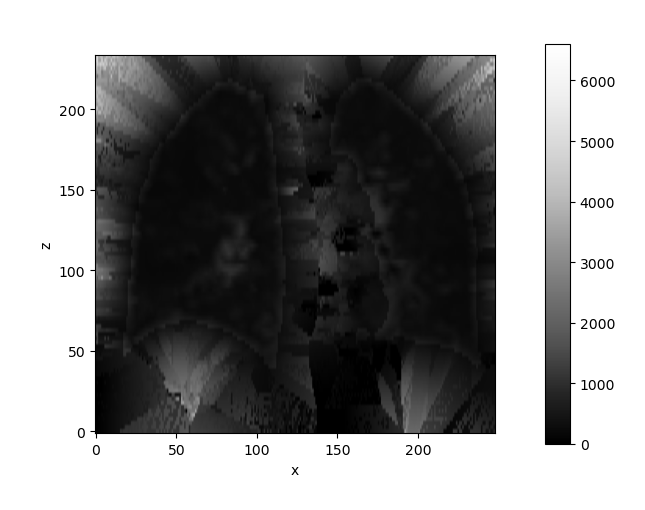

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


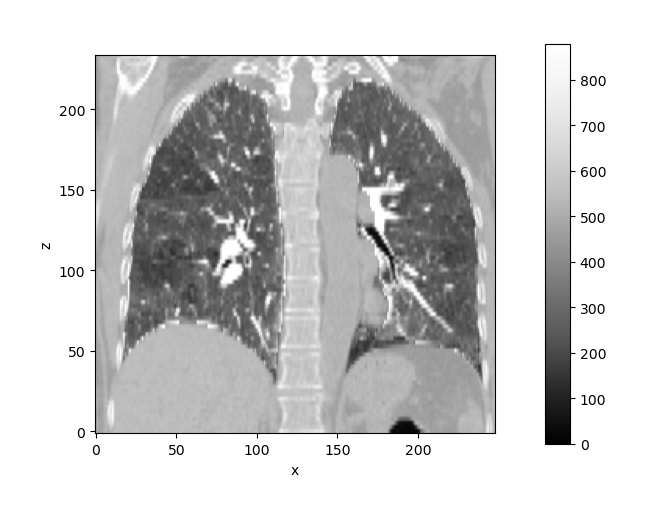

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [24]:
project.visual.XArrayViewer((ee_rho_image * 0 + rho_interp) * ee_overlay, x='x', y='z', vmin=0, cmap='Greys_r').update_index(y=140)
project.visual.XArrayViewer(ee_rho_image * ee_overlay, x='x', y='z', vmin=0, cmap='Greys_r').update_index(y=140)

## Physical model

Conservation of momentum
$$
    \nabla\cdot\sigma + \mathbf{b} = 0
$$

Isotropic linear elasticity
$$
    \sigma = 2 \mu \epsilon + \lambda \operatorname{tr}(\epsilon) \mathbf{I}
$$

Strain-displacement relation
$$
    \epsilon = \tfrac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
$$

Weak formulation
$$
\begin{align*}
    \nabla\cdot\sigma + \mathbf{b} &= 0 \\
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$



In [48]:
%%time
class PDESolver(torch_fenics.FEniCSModule):

    def __init__(self, mesh):
        super().__init__()
        
        # initialize function spaces
        self.scalar_space = fe.FunctionSpace(mesh, 'P', 1)
        self.vector_space = fe.VectorFunctionSpace(mesh, 'P', 1)
            
    def input_templates(self):
        return (
            fa.Function(self.vector_space), # u_true
            fa.Function(self.scalar_space), # mu
            fa.Function(self.scalar_space), # rho
        )

    def solve(self, u_true, mu, rho):

        # define physical parameters
        g   = 9.8 # gravitational acceleration (m/s^2)
        nu  = 0.4 # Poisson's ratio (unitless)
    
        lam = 2*mu*nu/(1 - 2*nu) # Lame's first parameter (Pa)

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.vector_space, u_true, 'on_boundary')

        # body force and traction
        b = fe.as_vector([-rho * g / 1000, 0, 0]) # m -> mm
        t = fa.Constant([0, 0, 0])

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam * fe.div(u) * I + 2 * mu * epsilon(u)

        # weak PDE formulation
        u = fe.TrialFunction(self.vector_space)
        v = fe.TestFunction(self.vector_space)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v) * fe.dx + fe.dot(t, v) * fe.ds

        # solve for displacement
        u_pred = fa.Function(self.vector_space)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred

pde_solver = PDESolver(ee_lung_fe_mesh)

u_tensor = torch.as_tensor(reg_disp_image.values)
mu_tensor = torch.ones(case.shape, dtype=torch.float64) * 3e3
rho_tensor = torch.as_tensor(ee_rho_image.values, dtype=torch.float64)

u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, pde_solver.vector_space)
u_func_dofs.requires_grad = False

mu_func_dofs = project.interpolate.image_to_dofs(mu_tensor, case.resolution, pde_solver.scalar_space)
mu_func_dofs.requires_grad = True

rho_func_dofs = project.interpolate.image_to_dofs(rho_tensor, case.resolution, pde_solver.scalar_space)
rho_func_dofs.requires_grad = False

u_pred_func_dofs = pde_solver.forward(
    u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0), rho_func_dofs.unsqueeze(0)
)[0]

CPU times: user 5 s, sys: 3.49 s, total: 8.49 s
Wall time: 2.67 s


In [49]:
# compute PDE-constrained loss and mu sensitivity

L = F.mse_loss(u_pred_func_dofs, u_func_dofs)
print(L)
L.backward()
print(u_func_dofs.grad)
print(mu_func_dofs.grad)

tensor(0.7192, dtype=torch.float64, grad_fn=<MseLossBackward0>)
None
tensor([ 0.0000e+00,  3.2828e-09,  0.0000e+00,  ..., -2.5656e-09,
        -1.7856e-09, -8.1868e-10], dtype=torch.float64)


In [50]:
# PDE-constrained optimization

def relative_error(u_pred, u_true):
    u_diff = u_pred - u_true
    u_diff_norm2 = (u_diff**2).sum(axis=-1)
    u_true_norm2 = (u_true**2).sum(axis=-1)
    return torch.mean(u_diff_norm2 / u_true_norm2)

mu_func_dofs.requires_grad = True
optimizer = torch.optim.Adam([mu_func_dofs], lr=1e1)

for i in range(1000):
    optimizer.zero_grad()

    u_pred_func_dofs = pde_solver.forward(
        u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0), rho_func_dofs.unsqueeze(0)
    )[0]

    loss = relative_error(u_pred_func_dofs, u_func_dofs)
    print((i+1), loss.item())

    loss.backward()
    optimizer.step()


1 0.8070134833185503
2 0.8004589093767799
3 0.793955578873075
4 0.7875039176679623
5 0.7811043186020857
6 0.774757140459505
7 0.7684627068084121
8 0.7622213050831882
9 0.7560331858759084
10 0.7498985624237103
11 0.7438176103236905
12 0.7377904674658818
13 0.7318172341412872
14 0.7258979732882921
15 0.7200327108694542
16 0.7142214363927338
17 0.7084641035925517
18 0.7027606312742647
19 0.6971109043115308
20 0.6915147747757764
21 0.6859720631717682
22 0.6804825597536238
23 0.6750460258994028
24 0.6696621955282781
25 0.6643307765494475
26 0.6590514523355457
27 0.6538238832148563
28 0.6486477079766593
29 0.6435225453833762
30 0.6384479956821505
31 0.6334236421080092
32 0.6284490523702042
33 0.6235237801136572
34 0.6186473663477413
35 0.6138193408352879
36 0.6090392234358141
37 0.6043065253975732
38 0.5996207505944197
39 0.5949813967042277
40 0.5903879563266621
41 0.5858399180389525
42 0.5813367673890559
43 0.5768779878263552
44 0.5724630615705547
45 0.5680914704199086
46 0.563762696500363


355 0.09400844435333222
356 0.093780953984643
357 0.09355619986602029
358 0.09333448092092754
359 0.09311598960441235
360 0.09290071020658773
361 0.09268841642354846
362 0.0924788195292978
363 0.09227180015613175
364 0.09206754398169106
365 0.09186646298362589
366 0.09166896994643452
367 0.09147527441115479
368 0.09128531455258264
369 0.09109882442118361
370 0.0909154584537402
371 0.0907348891439794
372 0.0905568386639808
373 0.09038105859551296
374 0.09020729872543908
375 0.09003529829183125
376 0.08986480877359102
377 0.08969563728673369
378 0.08952769247697331
379 0.0893610190799794
380 0.08919581939480688
381 0.08903247602433922
382 0.08887160311686139
383 0.08871413847318792
384 0.08856134954285383
385 0.08841408747154599
386 0.08826997906862298
387 0.08812182726432566
388 0.08796706758159743
389 0.08781163292805225
390 0.0876595558804128
391 0.08751089393077083
392 0.0873645765434282
393 0.08721970074801205
394 0.08707570098447147
395 0.08693226328107173
396 0.08678923763677206
3

699 0.06346078338029822
700 0.063365939351452
701 0.06333033367788192
702 0.0632927818195924
703 0.0632519210890083
704 0.06320822056904753
705 0.06316299168357474
706 0.06311671014103488
707 0.06306945403322006
708 0.06302123653184843
709 0.06297213992935666
710 0.06292228028608507
711 0.06287178195748054
712 0.06282076990032953
713 0.06276935463790559
714 0.06271763200214417
715 0.0626657094461313
716 0.0626137342178543
717 0.0625618617363042
718 0.06251013883989628
719 0.062458507962277476
720 0.062407087255970224
721 0.062356068032784935
722 0.06230528923350264
723 0.06225449678070755
724 0.062203883646173956
725 0.062153476369820784
726 0.062102817269793296
727 0.062052462551974774
728 0.06200175179232747
729 0.06195123229786594
730 0.0619027170819109
731 0.0620061460636582
732 0.06182703538253409
733 0.06181195174268482
734 0.06179253509712254
735 0.061768097412056404
736 0.06173910536406116
737 0.0617060330584288
738 0.06166922175246139
739 0.061628979680438005
740 0.06158571817

In [51]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_func_dofs, pde_solver.vector_space, case.shape, case.resolution)

CPU times: user 3min 10s, sys: 51 ms, total: 3min 10s
Wall time: 3min 10s


In [52]:
%%time
mu_pred_image = project.interpolate.dofs_to_image(mu_func_dofs, pde_solver.scalar_space, case.shape, case.resolution)

CPU times: user 3min 2s, sys: 49.1 ms, total: 3min 2s
Wall time: 3min 2s


<IPython.core.display.Javascript object>


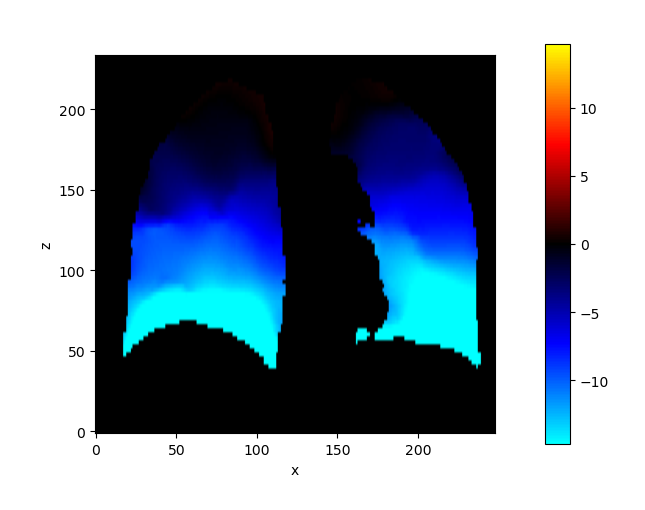

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


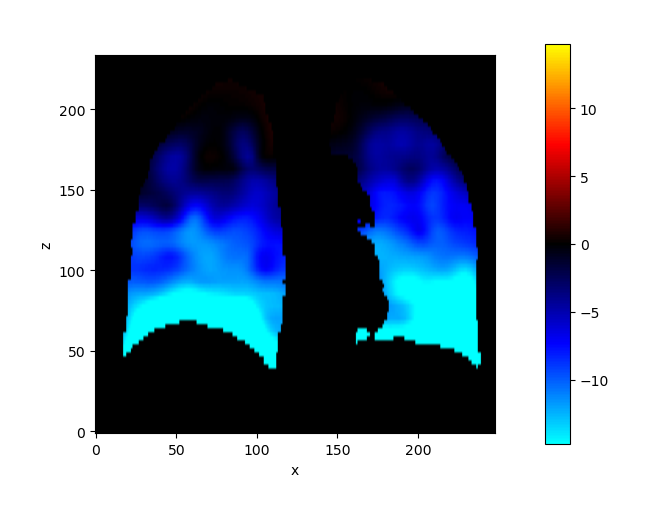

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


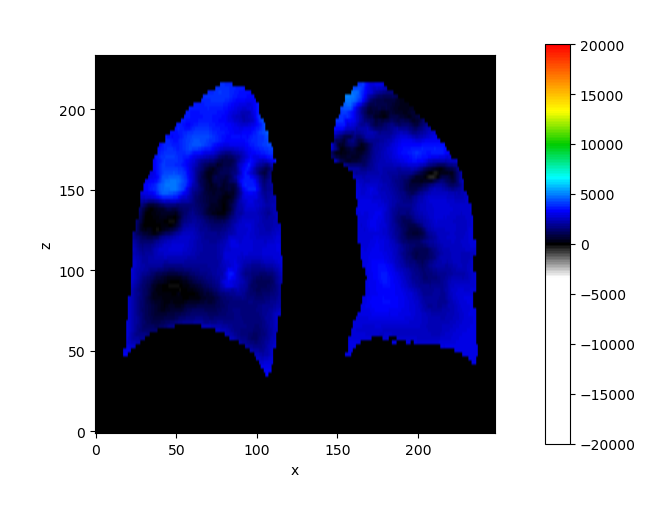

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [53]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_pred_image) * ee_lung_mask, x='x', y='z').update_index(y=140, component=2)
project.visual.XArrayViewer(reg_disp_image * ee_lung_mask, x='x', y='z').update_index(y=140, component=2)
project.visual.XArrayViewer(mu_pred_image * ee_lung_mask, x='x', y='z', cmap=project.visual.mre_color_map(), vmin=-2e4, vmax=2e4).update_index(y=140)

In [ ]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [ ]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')